# CAFEH Demo

Here we simulate some data and show how to use CAFEH to perform multi-trait fine-mapping and colocalization using individual level data or summary statistics

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from cafeh.cafeh import fit_cafeh_genotype, fit_cafeh_summary, fit_cafeh_z
from cafeh.model_queries import *

In [12]:
from cafeh.cafeh_genotype import CAFEHGenotype
from cafeh.cafeh_summary import CAFEHSummary

from cafeh.misc import plot_components
from cafeh.fitting import weight_ard_active_fit_procedure
from cafeh.model_queries import *

def fit_cafeh_genotype(X, y, K=10, init_args={}, fit_args = {}):
    """
    Fit CAFEH using individual level genotype data
    LD: LD matrix
    X: [p, n] matrix of genotypes
    y: [t, n] matrix of observtions
    n: int or [t] number of samples in each phenotype,
        if not provided a large sample approximation is made
    """
    cafehg = CAFEHGenotype(X, y, K=K, **init_args)
    weight_ard_active_fit_procedure(cafehg, **fit_args)
    return cafehg

def fit_cafeh_summary(LD, beta, stderr, n=np.inf, K=10, init_args={}, fit_args = {}):
    """
    Fit cafeh using reference LD, effect sizes, and standard errors
    
    LD: LD matrix
    beta: [t, p] matrix of effect sizes
    stderr: [t, p] matrix of standard error
    n: int or [t] number of samples in each phenotype,
        if not provided a large sample approximation is made
    """
    if not (type(n) == np.ndarray):
        n = np.ones(beta.shape[0]) * n
    S = np.sqrt(beta**2/n[:, None] + stderr**2)
    
    cafehs = CAFEHSummary(LD, B, S, K=K, **init_args)
    weight_ard_active_fit_procedure(cafehs, **fit_args)
    return cafehs


def fit_cafeh_z(LD, z, n=np.inf, K=10, init_args={}, fit_args={}):
    """
    Fit CAFEH using reference LD and zscores
    LD: LD matrix
    z: [t, p] matrix of z scores
    n: [t] number of samples in each phenotype,
        if not provided a large sample approximation is made
    """
    Z =  z / np.sqrt((z**2 + n[:, None]) / n[:, None])
    cafehz = CAFEHSummary(LD, Z, np.ones_like(z), K=K, **init_args)
    weight_ard_active_fit_procedure(cafehz, max_iter=100)
    return cafehz

### Simulate some data

First we simulate some data. We generate 3 phenotypes that all have a distinct causal variant, and a fourth causal variant shared across the 4

We generate multivariate normal "genotype" data where SNPs are correlated with their neighbors in an exponentially decaying manner.

In [2]:
t = 3  # number of phenotypes
n = 500  # number of samples
p = 1000  # number of features (SNPs)

# simulate some correlated features X
mix = np.exp(-np.abs(np.arange(p) - np.arange(p)[:, None])/50)
X = (np.random.normal(size=(n, p)) @ mix).T

# simulate phenotypes: each with a distinct causal variant and all with a shared causal variant
causal = np.zeros((t, p))
causal[0, [100, 500]] = 1
causal[1, [150, 500]] = 1
causal[2, [200, 500]] = 1

y = causal @ X + np.random.normal(size=(t, n)) * 3

### Compute summary statistics

Next we compute effect sizes and standard errors to use in the summary stat version of CAFEH

In [3]:
y_centered = y - y.mean(1)[:, None]
X_centered = X - X.mean(1)[:, None]

d = np.diag(X_centered @ X_centered.T)
B = (y_centered @ X_centered.T) / d[None]

sq_error = np.array([((y_centered[i][:, None] - X_centered.T * B[i])**2).sum(0) for i in range(t)])
stderr = np.sqrt(sq_error / (n-1) / d[None])
S = np.sqrt(B**2/n + stderr**2)
LD = np.corrcoef(X)

Text(0.5, 1.0, 'Simulation LD Matrix')

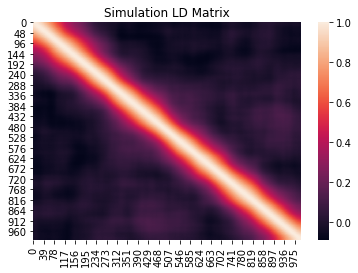

In [4]:
sns.heatmap(np.corrcoef(X))
plt.title('Simulation LD Matrix')

## Fitting CAFEH

We provide routines for fitting CAFEH using either individual level data or summary stats. We offer 3 routines, `fit_cafeh_genotype`, `fit_cafeh_summary` and `fit_cafeh_z` to make the process simple.

### Fit with `CAFEHGenotype`

The individual level version of CAFEH is implimented in `CAFEHGenotype`. `fit_cafeh_genotype` is a routine for initializing and fitting the model. `fit_cafeh_genotype` that accepts the following inputs

You will need
`X` an $p \times n$ genotype matrix
`Y` a $t \times n$ phenotype matrix
`cov` (optional) DataFrame of covariatiats.
`init_args` (optional) a dictionary of arguments to pass to the `CAFEHGenotype` initializer.
`fit_args` (optional) a dictionary of arguments to pass to the `weight_ard_active_fit_procedure`


**A note on covariates** 

Please note that if you are using covariates the covariates should be formatted as a `pandas.DataFrame` with a 2-level index `[study_id, covariate_name]` and column names that correspond with `sample_ids`. This is necessary because not all phenotypes need by observed in all individuals, so the model needs to know which covariates are relevant to each sample. You must also specify `sample_ids`, `snp_ids`, and `study_ids`, e.g

`labels = {'sample_ids': sample_ids, 'snp_ids':snp_ids', 'study_ids':study_ids}`

`model = CAFEHGenotype(X, y, K=10, init_args=labels)`


**Fitting procedure `weight_ard_active_fit_procedure`** 

In the `fit_` routines we fit the model using `weight_ard_active_fit_procedure`. CAFEH's likelihood is non-convex, we find this procedure avoids local optima during model fitting, and generally leads to acceptable results. We fit the model in 3 stages.

1. Fit the weights holding estimating prior variance and assignments fixed
2. Fit the weights + weight variances holding assignments fixed
3. Fit all parameters in the model

### Alternative fit procedures

If you would like to try something else, `CAFEHGenotype` and `CAFEHSummary` both impliment a `fit` method that allows you to toggle updates for all of the models parameters via keyword arguments.

Initialze the model with

`cafehg = CAFEHGenotype(X, y, K=K, **init_args)`

Specify which parameters you want to update

`fit_args = {update_pi=True, update_weights=True, max_iter=10}`

And then fit
`cafehg.fit(**fit_args)`
    

In [5]:
%%time
cafehg = fit_cafeh_genotype(X, y, K=10)

CPU times: user 1.89 s, sys: 55 ms, total: 1.95 s
Wall time: 494 ms


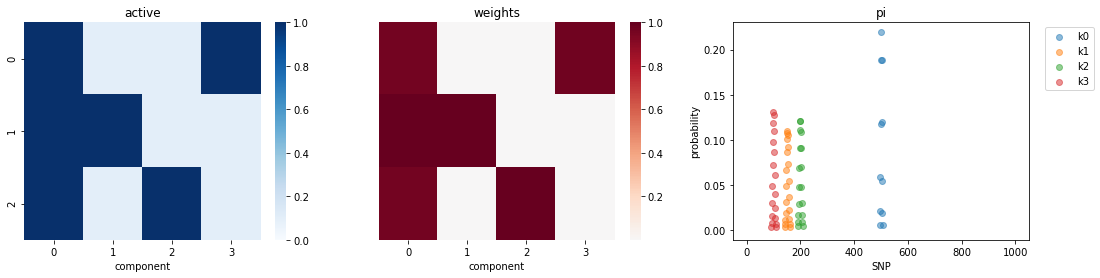

In [6]:
# plot
cafehg.plot_components()

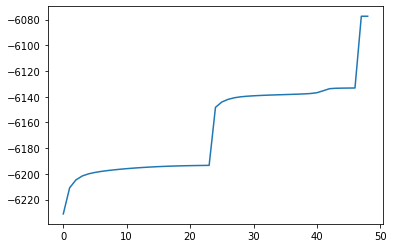

In [7]:
# check ELBO is monotonically increasing
# note that 3 "bumps" are the 3 different stages of model fitting
plt.plot(cafehg.elbos)

In [11]:
# Get 95% Credible sets for each component
credible_sets = cafehg.get_credible_sets(0.95)
credible_sets[0], credible_sets[1], credible_sets[2], credible_sets[3]

(array([501, 502, 500, 503, 499, 498, 504, 497]),
 array([152, 151, 153, 150, 154, 149, 155, 148, 156, 147, 157, 146, 158,
        145]),
 array([200, 199, 198, 201, 197, 202, 203, 196, 204, 195, 205, 194, 206]),
 array([100, 101,  99, 102,  98, 103,  97, 104,  96, 105,  95, 106,  94]))

In [12]:
# summarize results in a table
variant_report = summary_table(cafehg, True, max_snps=500, min_p_active=0.5)
variant_report.sort_values('alpha').head(n=6)

,variant_id,study,pip,top_component,alpha,rank,p_active,pi,effect,effect_var
2501,501,2,0.219747,0,0.000000,0,1.0,0.219286,0.962546,0.004692
1501,501,1,0.219742,0,0.000000,0,1.0,0.219286,0.994136,0.004914
501,501,0,0.219747,0,0.000000,0,1.0,0.219286,0.968367,0.004539
2502,502,2,0.189255,0,0.219286,1,1.0,0.188777,0.962255,0.004688
1502,502,1,0.189250,0,0.219286,1,1.0,0.188777,0.992977,0.004910
502,502,0,0.189255,0,0.219286,1,1.0,0.188777,0.967864,0.004536


### Saving the model


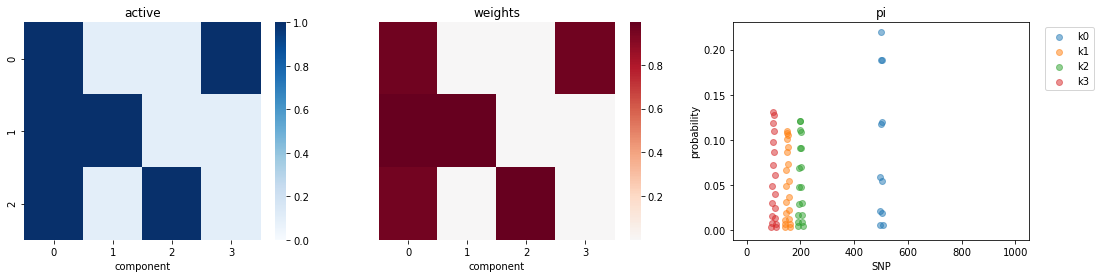

In [22]:
# save model
# by default we do not save the data with the model, if you want the data set save_data=True
cafehg.save('./saved_model.pkl', save_data=True)

# load model
# we save a compact version of the model, when you load the model call _decompress_model()

import pickle
cafehg_reload = pickle.load(open('saved_model.pkl', 'rb'))
cafehg_reload._decompress_model()
cafehg_reload.plot_components()

### Fit CAFEH with summary stats

The summary stat version of CAFEH is implimented in `CAFEHSummary`.

If you have effect sizes and standard error you can use `fit_cafeh_summary`.
If you have z-scores you can use `fit_cafeh_z`. 

Please note that with `fit_cafeh_z`, the scale of the weights may not be comparable across multiple phenotypes, especially if there were a different number of samples in each phenotype, since z-scores conflate effect size and significance.

Implementation of `CAFEHSummary` is based off of the Regression form Summary Statistics (RSS) likelihood of Zhu and Stephens [1]. We impliment a stochastic optimization routine which. At each iteration we sample an active SNP for each component according the to current posterior estimates `pi`.

### Fit with betas and standard errors

In [13]:
%%time
cafehs = fit_cafeh_summary(LD, B, stderr, n=n)
cafehs.plot_components()

NameError: name 'CAFEHSummary' is not defined

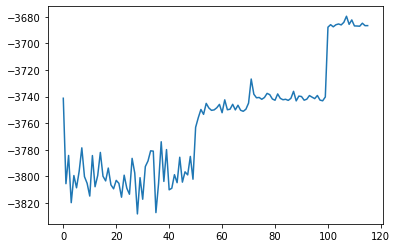

In [64]:
plt.plot(cafehs.elbos)

In [65]:
%%time
cafehs = fit_cafeh_z(LD, B/stderr, n=np.ones(3)*n)

CPU times: user 6.6 s, sys: 33.8 ms, total: 6.63 s
Wall time: 1.66 s


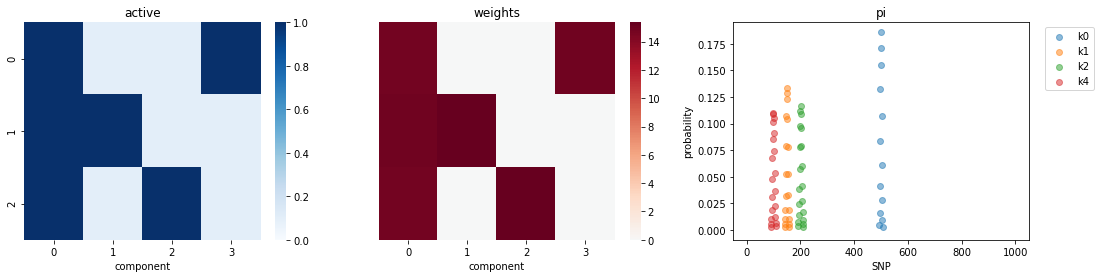

In [66]:
cafehs.plot_components()

### References 

1. Zhu, X., & Stephens, M. (2017). Bayesian large-scale multiple regression with summary statistics from genome-wide association studies. The annals of applied statistics, 11(3), 1561.
